Generating audio and spectrograms...
Successfully generated audio: 5_COMPARE_OUT/AUDIO/Nocturne_Op48_No1_Cm/Nocturne_Op48_No1_Cm_CRNN Original.wav
Successfully generated audio: 5_COMPARE_OUT/AUDIO/Nocturne_Op48_No1_Cm/Nocturne_Op48_No1_Cm_CRNN Pre-processing.wav
Successfully generated audio: 5_COMPARE_OUT/AUDIO/Nocturne_Op48_No1_Cm/Nocturne_Op48_No1_Cm_CRNN Pre-post processing.wav

Plotting source and aligned spectrograms in a 2x2 figure...


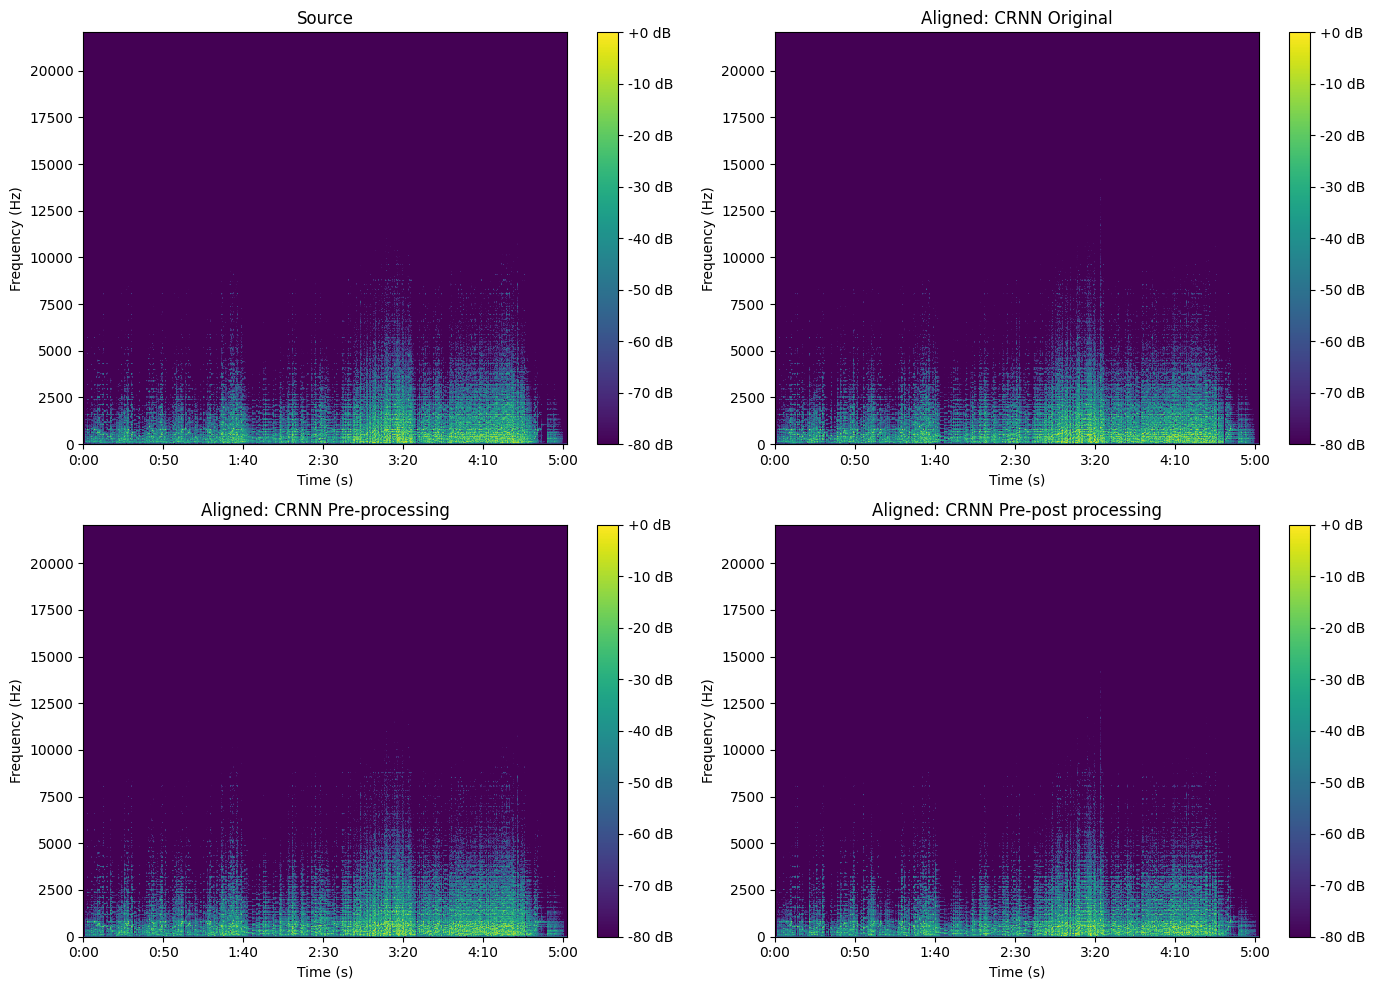

Combined spectrogram plot saved to: 5_COMPARE_OUT/PLOTS/Nocturne_Op48_No1_Cm/Nocturne_Op48_No1_Cm_spectrograms_combined.png

Plotting spectrogram overlays of aligned audio with the source...


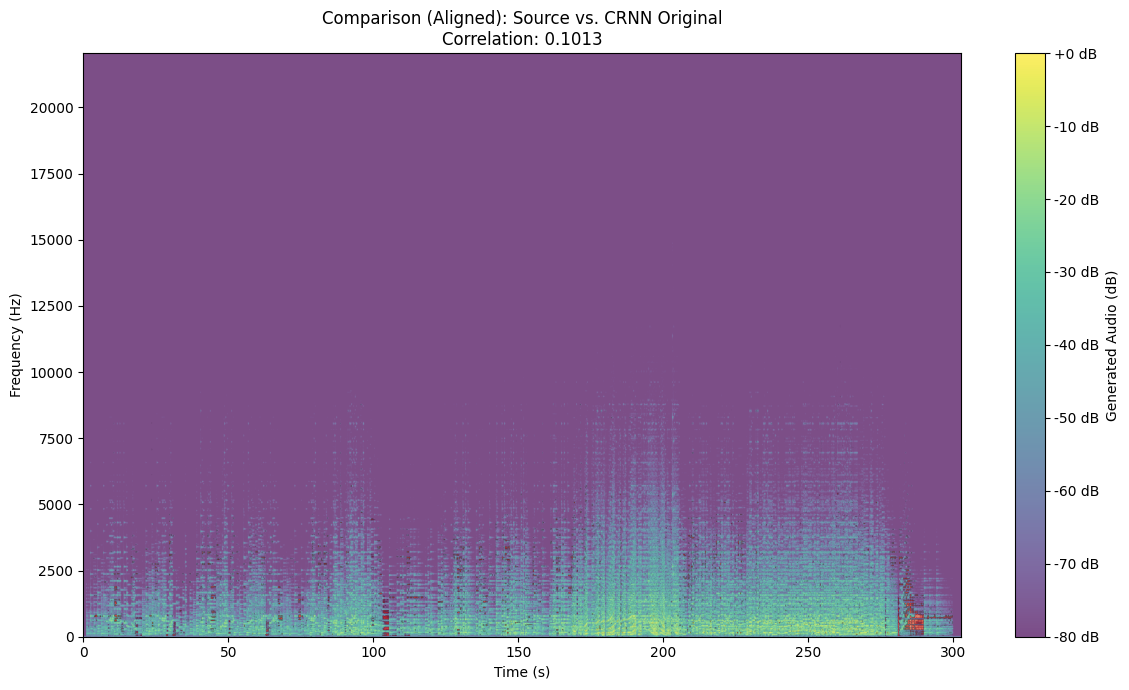

Spectrogram overlay saved to: 5_COMPARE_OUT/PLOTS/Nocturne_Op48_No1_Cm/Nocturne_Op48_No1_Cm_comparison_aligned_CRNN Original.png


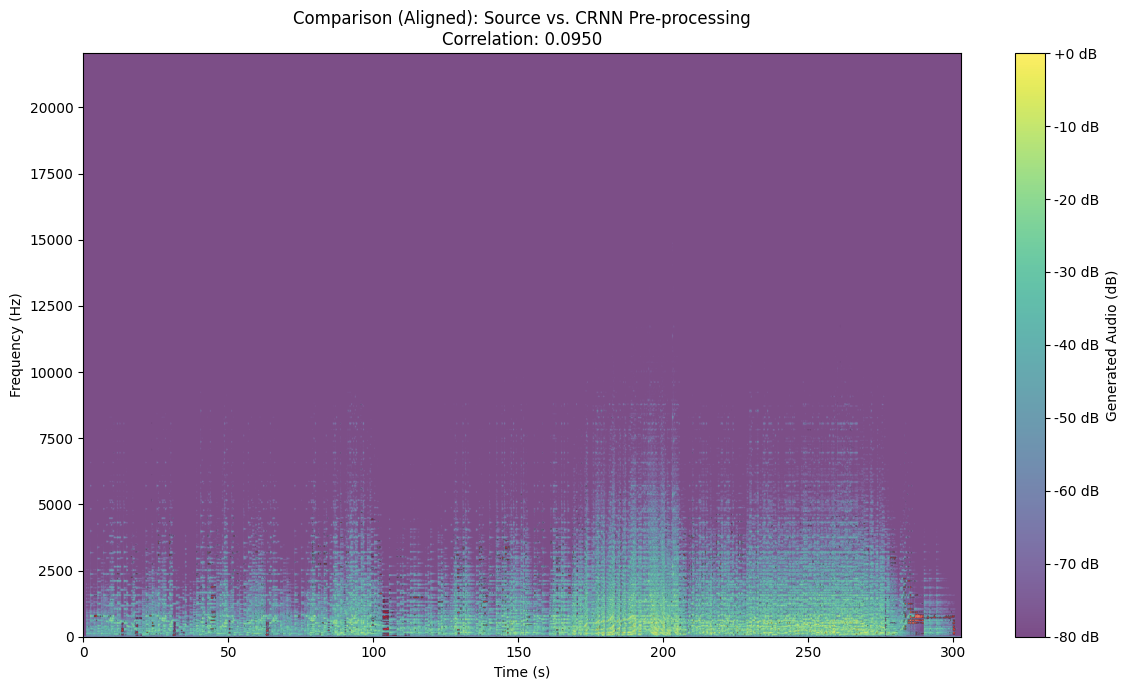

Spectrogram overlay saved to: 5_COMPARE_OUT/PLOTS/Nocturne_Op48_No1_Cm/Nocturne_Op48_No1_Cm_comparison_aligned_CRNN Pre-processing.png


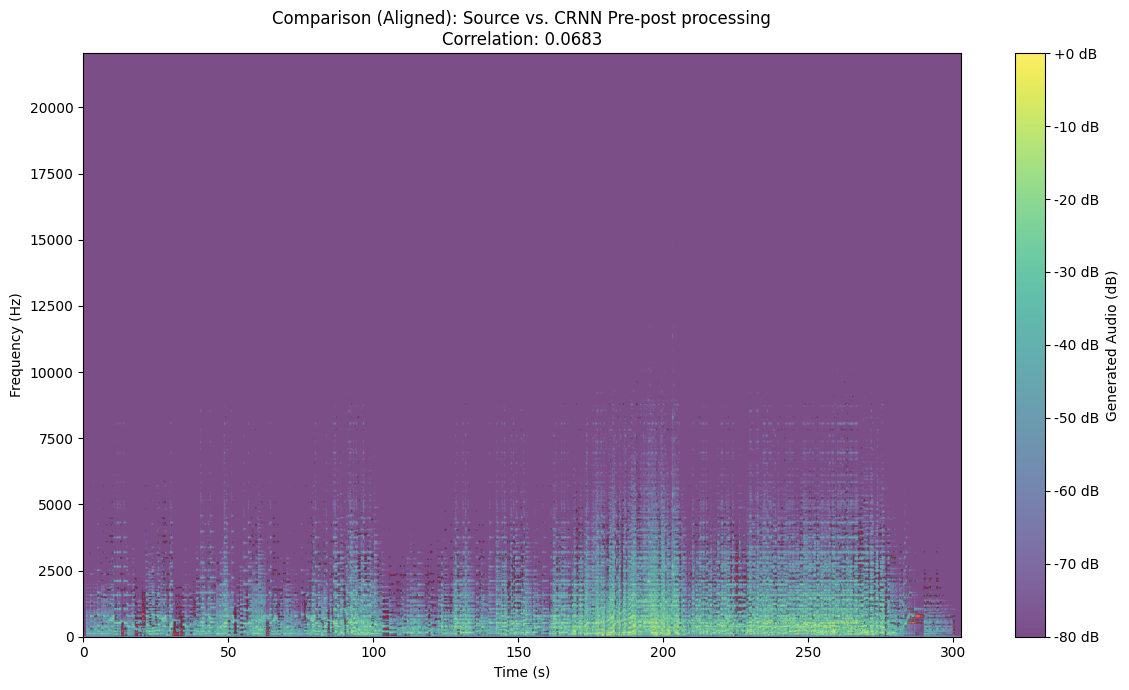

Spectrogram overlay saved to: 5_COMPARE_OUT/PLOTS/Nocturne_Op48_No1_Cm/Nocturne_Op48_No1_Cm_comparison_aligned_CRNN Pre-post processing.png
Spectrogram plotting of aligned audio complete.


In [11]:
import os
import subprocess
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, ifft
import soundfile as sf
from scipy.signal import correlate  # Import the correlate function

global soundfont
global midi_name
global soundfont_path

soundfont = "Yamaha_S6"
midi_name = "velocity_test_69"

soundfont_path = os.path.join("SOURCES/SOUNDFONTS/", soundfont + ".sf2")
source_midi_path = os.path.join("SOURCES/MIDI/", midi_name + ".midi")
crnn_original_midi_path = f"3_GENERATE_OUT/MIDI/{midi_name}_{soundfont}.mid"
crnn_pre_midi_path = f"3_GENERATE_OUT/MIDI/{midi_name}_{soundfont}_pre.mid"
crnn_pre_post_midi_path = f"4_POSTPROCESS_OUT/MIDI/{midi_name}/{midi_name}_{soundfont}_pre_post.mid"

outputs_path = "5_COMPARE_OUT/"
audio_path = os.path.join(outputs_path, f"AUDIO/{midi_name}/")
plot_path = os.path.join(outputs_path, f"PLOTS/{midi_name}/")
os.makedirs(audio_path, exist_ok=True)
os.makedirs(plot_path, exist_ok=True)

def generate_audio(midi_path, output_path, soundfont_path):
    """Generates audio from a MIDI file using fluidsynth."""
    cmd = [
        "fluidsynth",
        "-ni",
        soundfont_path,
        midi_path,
        "-F",
        output_path,
        "-r",
        "44100",
    ]
    try:
        subprocess.run(cmd, check=True, capture_output=True)
        print(f"Successfully generated audio: {output_path}")
    except subprocess.CalledProcessError as e:
        print(f"Error generating audio for {midi_path}: {e}")
        print(f"Stderr: {e.stderr.decode()}")
        return False
    return True

def create_spectrogram(audio_path, max_duration=None):
    """Creates the spectrogram data (dB scaled magnitude) for an audio file, optionally trimming to max_duration (seconds)."""
    try:
        y, sr = librosa.load(audio_path, sr=None)

        # Trim audio to max duration if provided
        if max_duration:
            max_samples = int(max_duration * sr)
            y = y[:max_samples]

        y = y / np.max(np.abs(y)) if np.max(np.abs(y)) != 0 else y

        n_fft = 2048
        hop_length = 512
        stft_result = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
        magnitude_db = librosa.amplitude_to_db(np.abs(stft_result), ref=np.max)
        return magnitude_db, sr, hop_length, librosa.get_duration(y=y, sr=sr)
    except Exception as e:
        print(f"Error creating spectrogram data for {audio_path}: {e}")
        return None, None, None, None

def align_audio_fft(signal1, signal2):
    """
    Aligns two audio signals using cross-correlation via FFT for speed.

    Args:
        signal1 (np.ndarray): The first audio signal.
        signal2 (np.ndarray): The second audio signal to align to the first.

    Returns:
        int: The shift (in samples) needed to align signal2 to signal1.
             A positive shift means signal2 is delayed relative to signal1.
             A negative shift means signal2 is ahead of signal1.
        np.ndarray: The cross-correlation array.
        float: The normalized cross-correlation score.
    """
    n1 = len(signal1)
    n2 = len(signal2)

    # Pad the shorter signal with zeros to the length of the longer signal
    if n1 < n2:
        padded_signal1 = np.pad(signal1, (0, n2 - n1), 'constant')
        padded_signal2 = signal2
    elif n2 < n1:
        padded_signal2 = np.pad(signal2, (0, n1 - n2), 'constant')
        padded_signal1 = signal1
    else:
        padded_signal1 = signal1
        padded_signal2 = signal2

    # Calculate cross-correlation using FFT
    fft_signal1 = fft(padded_signal1)
    fft_signal2_conj = np.conjugate(fft(padded_signal2))
    cross_correlation_fft = ifft(fft_signal1 * fft_signal2_conj)
    cross_correlation = np.real(cross_correlation_fft)

    # Find the index of the peak correlation
    delay = np.argmax(cross_correlation) - (len(padded_signal1) - 1)

    # Calculate normalized cross-correlation
    norm_corr = np.max(cross_correlation) / np.sqrt(np.sum(padded_signal1**2) * np.sum(padded_signal2**2)) if np.sum(padded_signal1**2) > 0 and np.sum(padded_signal2**2) > 0 else 0

    return delay, cross_correlation, norm_corr

def display_spectrogram_overlay(source_mag_db, source_sr, source_hop_length,
                                 generated_mag_db_aligned, generated_sr, generated_hop_length,
                                 title, correlation_score=None, output_path="spectrogram_overlay.png", threshold_db=10.0):
    if source_sr != generated_sr or source_hop_length != generated_hop_length:
        print("Warning: Sampling rate or hop length differs between source and generated audio. Overlay might be misaligned.")
        return

    n_frames_source = source_mag_db.shape[1]
    n_frames_generated = generated_mag_db_aligned.shape[1]
    min_frames = min(n_frames_source, n_frames_generated)

    source_trimmed = source_mag_db[:, :min_frames]
    generated_trimmed = generated_mag_db_aligned[:, :min_frames]

    plt.figure(figsize=(12, 7)) # Increased height to accommodate the score

    # Display the generated spectrogram with some transparency
    plt.imshow(generated_trimmed, extent=[0, librosa.frames_to_time(generated_trimmed.shape[1], sr=generated_sr, hop_length=generated_hop_length), 0, generated_sr / 2],
               aspect='auto', origin='lower', cmap='viridis', alpha=0.7)
    plt.colorbar(format='%+2.0f dB', label='Generated Audio (dB)')

    # Calculate the absolute difference
    difference_db = np.abs(generated_trimmed - source_trimmed)

    # Create a mask for significant differences
    diff_mask = difference_db > threshold_db

    # Overlay the difference mask with a contrasting color (e.g., red)
    plt.imshow(np.where(diff_mask, difference_db, np.nan), extent=[0, librosa.frames_to_time(generated_trimmed.shape[1], sr=generated_sr, hop_length=generated_hop_length), 0, generated_sr / 2],
               aspect='auto', origin='lower', cmap='Reds_r', alpha=0.8) # Reds_r for reversed red colormap

    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    if correlation_score is not None:
        plt.title(f"{title}\nCorrelation: {correlation_score:.4f}")
    else:
        plt.title(title)
    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()
    print(f"Spectrogram overlay saved to: {output_path}")


def compute_volume_difference(source_mag_db, generated_mag_db, hop_length, sr):
    """Compute a scalar 'volume difference' metric between two spectrograms."""
    min_frames = min(source_mag_db.shape[1], generated_mag_db.shape[1])
    source_mag_db = source_mag_db[:, :min_frames]
    generated_mag_db = generated_mag_db[:, :min_frames]

    # Convert dB back to linear scale
    source_lin = librosa.db_to_amplitude(source_mag_db)
    generated_lin = librosa.db_to_amplitude(generated_mag_db)

    # Compute the absolute difference in amplitude
    diff = np.abs(source_lin - generated_lin)

    frame_duration = hop_length / sr
    bin_width = sr / (2 * source_mag_db.shape[0]) if source_mag_db.shape[0] > 0 else 1 # Estimate bin width
    volume_diff = np.sum(diff) * bin_width * frame_duration
    return volume_diff

def plot_spectrogram(mag_db, sr, hop_length, title, ax, fig):
    """Plots a single spectrogram on a given matplotlib axes."""
    img = librosa.display.specshow(mag_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='hz', cmap='viridis', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Frequency (Hz)')
    fig.colorbar(img, format='%+2.0f dB', ax=ax)

if __name__ == "__main__":
    midi_files_to_process = {
        "CRNN Original": crnn_original_midi_path,
        "CRNN Pre-processing": crnn_pre_midi_path,
        "CRNN Pre-post processing": crnn_pre_post_midi_path,
    }

    print("Generating audio and spectrograms...")

    source_audio_path = os.path.join(audio_path, f"{midi_name}_Original.wav")
    if not os.path.exists(source_audio_path):
        if not generate_audio(source_midi_path, source_audio_path, soundfont_path):
            print(f"Error generating audio for source MIDI. Skipping comparison.")
            exit()

    source_y, source_sr_audio = librosa.load(source_audio_path, sr=None)
    source_mag_db, source_sr_spec, source_hop_length, source_duration = create_spectrogram(source_audio_path)
    if source_mag_db is None:
        print(f"Error creating spectrogram for source audio. Skipping comparison.")
        exit()

    midi_files_for_comparison = {
        "CRNN Original": crnn_original_midi_path,
        "CRNN Pre-processing": crnn_pre_midi_path,
        "CRNN Pre-post processing": crnn_pre_post_midi_path,
    }

    aligned_generated_spectrograms = {}

    for name, midi_path in midi_files_for_comparison.items():
        generated_audio_path = os.path.join(audio_path, f"{midi_name}_{name}.wav")

        if generate_audio(midi_path, generated_audio_path, soundfont_path):
            generated_y, generated_sr_audio = librosa.load(generated_audio_path, sr=None)
            generated_mag_db_unaligned, generated_sr_spec, generated_hop_length_spec, _ = create_spectrogram(generated_audio_path, max_duration=source_duration)

            if generated_mag_db_unaligned is not None:
                # Perform audio alignment
                if source_sr_audio == generated_sr_audio:
                    shift, _, correlation = align_audio_fft(source_y, generated_y)
                    aligned_generated_y = np.roll(generated_y, -shift)

                    # Save the aligned audio to a temporary file
                    temp_aligned_audio_path = os.path.join(audio_path, f"temp_aligned_{name}.wav")
                    sf.write(temp_aligned_audio_path, aligned_generated_y, generated_sr_audio)

                    # Create spectrogram for the aligned audio using the file path
                    aligned_generated_mag_db, _, _, _ = create_spectrogram(temp_aligned_audio_path, max_duration=source_duration)

                    # Clean up the temporary file
                    os.remove(temp_aligned_audio_path)

                    if aligned_generated_mag_db is not None:
                        aligned_generated_spectrograms[name] = (aligned_generated_mag_db, generated_sr_spec, generated_hop_length_spec, correlation)
                    else:
                        print(f"Error creating spectrogram for aligned audio file: {temp_aligned_audio_path}")
                else:
                    print(f"Warning: Sampling rates differ ({source_sr_audio} vs {generated_sr_audio}). Cannot perform audio alignment.")
                    # If no alignment, use the unaligned spectrogram for plotting (without correlation score)
                    aligned_generated_spectrograms[name] = (generated_mag_db_unaligned, generated_sr_spec, generated_hop_length_spec, None)
            else:
                print(f"Error creating spectrogram for unfiltered audio: {generated_audio_path}")
        else:
            print(f"Error generating audio for: {midi_path}")

    print("\nPlotting source and aligned spectrograms in a 2x2 figure...")
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()  # Flatten the 2x2 array of axes for easy indexing

    plot_spectrogram(source_mag_db, source_sr_spec, source_hop_length, "Source", axes[0], fig)

    if len(aligned_generated_spectrograms) > 0:
        names = list(aligned_generated_spectrograms.keys())
        data = list(aligned_generated_spectrograms.values())

        if len(data) > 0:
            mag_db, sr, hop_length, _ = data[0]
            plot_spectrogram(mag_db, sr, hop_length, f"Aligned: {names[0]}", axes[1], fig)
        if len(data) > 1:
            mag_db, sr, hop_length, _ = data[1]
            plot_spectrogram(mag_db, sr, hop_length, f"Aligned: {names[1]}", axes[2], fig)
        if len(data) > 2:
            mag_db, sr, hop_length, _ = data[2]
            plot_spectrogram(mag_db, sr, hop_length, f"Aligned: {names[2]}", axes[3], fig)
        elif len(data) < 3:
            for i in range(len(data), 4):
                fig.delaxes(axes[i]) # Remove unused subplots

        plt.tight_layout()
        output_path_combined = os.path.join(plot_path, f"{midi_name}_spectrograms_combined.png")
        plt.savefig(output_path_combined)
        plt.show()
        print(f"Combined spectrogram plot saved to: {output_path_combined}")
    else:
        print("No aligned spectrograms to plot in the combined figure.")

    print("\nPlotting spectrogram overlays of aligned audio with the source...")
    for name, (aligned_mag_db, aligned_sr, aligned_hop_length, correlation) in aligned_generated_spectrograms.items():
        title = f"Comparison (Aligned): Source vs. {name}"
        output_filename = os.path.join(plot_path, f"{midi_name}_comparison_aligned_{name}.png")
        display_spectrogram_overlay(
            source_mag_db, source_sr_spec, source_hop_length,
            aligned_mag_db, aligned_sr, aligned_hop_length,
            title, correlation_score=correlation, output_path=output_filename, threshold_db=15.0
        )

    print("Spectrogram plotting of aligned audio complete.")

In [12]:
from mido import MidiFile

def print_velocity_values(midi_file_path):
    """
    Reads a MIDI file and prints the velocity values of all Note On events.

    Args:
        midi_file_path (str): The path to the MIDI file.
    """
    try:
        midi_file = MidiFile(midi_file_path)
        print(f"Velocity values in '{midi_file_path}':")
        for i, track in enumerate(midi_file.tracks):
            print(f"\nTrack {i}: {track.name}")
            for msg in track:
                if msg.type == 'note_on':
                    print(f"  - Note: {msg.note}, Velocity: {msg.velocity}, Time: {msg.time}")
    except FileNotFoundError:
        print(f"Error: MIDI file not found at '{midi_file_path}'")
    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == '__main__':
    print_velocity_values(source_midi_path)
    print_velocity_values(crnn_pre_post_midi_path)

Velocity values in 'SOURCES/MIDI/Nocturne_Op48_No1_Cm.midi':

Track 0: 

Track 1: 
  - Note: 48, Velocity: 33, Time: 14
  - Note: 36, Velocity: 27, Time: 9
  - Note: 36, Velocity: 0, Time: 192
  - Note: 48, Velocity: 0, Time: 49
  - Note: 79, Velocity: 66, Time: 620
  - Note: 63, Velocity: 30, Time: 20
  - Note: 55, Velocity: 26, Time: 26
  - Note: 67, Velocity: 12, Time: 5
  - Note: 67, Velocity: 0, Time: 168
  - Note: 63, Velocity: 0, Time: 68
  - Note: 55, Velocity: 0, Time: 72
  - Note: 79, Velocity: 0, Time: 205
  - Note: 36, Velocity: 31, Time: 20
  - Note: 48, Velocity: 37, Time: 0
  - Note: 36, Velocity: 0, Time: 90
  - Note: 48, Velocity: 0, Time: 94
  - Note: 80, Velocity: 71, Time: 892
  - Note: 56, Velocity: 34, Time: 13
  - Note: 68, Velocity: 40, Time: 9
  - Note: 63, Velocity: 36, Time: 4
  - Note: 68, Velocity: 0, Time: 206
  - Note: 63, Velocity: 0, Time: 62
  - Note: 56, Velocity: 0, Time: 107
  - Note: 80, Velocity: 0, Time: 154
  - Note: 47, Velocity: 42, Time: 644
